In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os

In [2]:
dig_out_dir = '/home/lmoroni/__workdir/DIG/output'

In [3]:
def get_model_config(model_str):
    model_config = dict()
    model_str = model_str.split('_')
    model_config['language_mode'] = 'cross_lingual' if 'xlm' in model_str[0] else 'mono_lingual'
    model_config['pretrained'] = True if model_str[1] == 'p' else False
    model_config['finetuned'] = True if model_str[2] == 'f' else False
    model_config['language'] = 'it' if 'it' in model_str[-1] else 'en'
    model_config['user'] = int(model_str[-1][2:]) if model_config['finetuned'] else 0
    return model_config

In [4]:
def load_dig_results(src_dir):
    filtered_res_dict = dict()
    res_path = os.path.join(src_dir, 'xai_metrics.json')
    with open(res_path, 'r') as res_file:
        res_dict = json.load(res_file)
    for key, value in res_dict.items():
        if 'comp' not in key and 'suff' not in key:
            filtered_res_dict[key] = value
    return filtered_res_dict

In [5]:
def init_res_dict(model_config, model_res):
    res_dict = dict()
    for key in list(model_config.keys()) + list(model_res.keys()):
        res_dict[key] = []
    return res_dict

In [6]:
def create_label(language, group_name):
    language_mode_str = '_ml' if group_name[0] == 'cross_lingual' else ''
    pretrained_str = '_p' if group_name[1] == True else '_np'
    return language+language_mode_str+pretrained_str

In [7]:
def sort_index(index):
    index = index.tolist()
    int_values = [val for val in index if type(val) == type(1)]
    sorted_index = sorted(int_values)+['avg', 'no']
    return sorted_index

In [8]:
def plot_heatmap(data, ax, language, metric):
    if task == 'complexity':
        if metric == 'reg_log_odd':
            vmin = 0.05
            vmax = 0.44
        else:
            vmin = 0.17
            vmax = 1.61
        
    if metric in ['reg_log_odd', 'log_odd']:
        arrow = '↑'
        cmap = 'GnBu'
    else: 
        arrow = '↓'
        cmap = 'GnBu_r'
    sns.heatmap(ax=ax, data=data, annot=True, fmt=".2f", cmap=cmap, cbar=False, linewidth=.5).set_title(f'Metric = {metric} ({arrow})')
    ax.hlines([5], *ax.get_xlim(), color='white', linewidths=3)
    if language == 'en':
        ax.set(ylabel='Eye-gaze fine-tuning')
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)

In [9]:
def create_heatmap_data(groups, language, metric):
    heatmap_data = None
    columns = metric_df['user'].unique()
    for group_name, group_data in groups:
        label = create_label(language, group_name)
        row_data = pd.DataFrame({user: group_data[group_data['user'] == user][metric].values[0] for user in columns}, index=[label])
        if heatmap_data is None:
            heatmap_data = row_data
        else:
            heatmap_data = pd.concat([heatmap_data, row_data])#, ignore_index=True)
    heatmap_data = heatmap_data.rename(columns={0: 'no'})
    heatmap_data['avg'] = heatmap_data.drop(columns=['no']).mean(axis=1)
    heatmap_data_T = heatmap_data.T
    heatmap_data_T = heatmap_data_T.reindex(sort_index(heatmap_data_T.index))
    return heatmap_data_T[sorted(heatmap_data_T.columns, reverse=True)]

# Complexity

In [10]:
src_dir = os.path.join(dig_out_dir, 'complexity_10_50')

In [11]:
task = 'complexity'

In [12]:
res_dict = None
metrics = None
for model_dir_name in os.listdir(src_dir):
    model_dir_path = os.path.join(src_dir, model_dir_name)
    model_config = get_model_config(model_dir_name)
    model_res = load_dig_results(model_dir_path)
    if res_dict is None:
        res_dict = init_res_dict(model_config, model_res)
        metrics = list(model_res.keys())
    for model_dict in [model_config, model_res]:
        for key, value in model_dict.items():
            res_dict[key].append(value)

In [13]:
all_df = pd.DataFrame.from_dict(res_dict)

In [14]:
all_df.head()

,language_mode,pretrained,finetuned,language,user,reg_log_odd,reg_anti_log_odd
0,cross_lingual,False,True,it,1,0.152971,0.787428
1,cross_lingual,False,True,en,49,0.109308,0.847361
2,cross_lingual,True,True,it,44,0.181954,0.261424
3,cross_lingual,False,False,en,0,0.105527,0.930977
4,mono_lingual,False,True,it,38,0.160101,1.043719


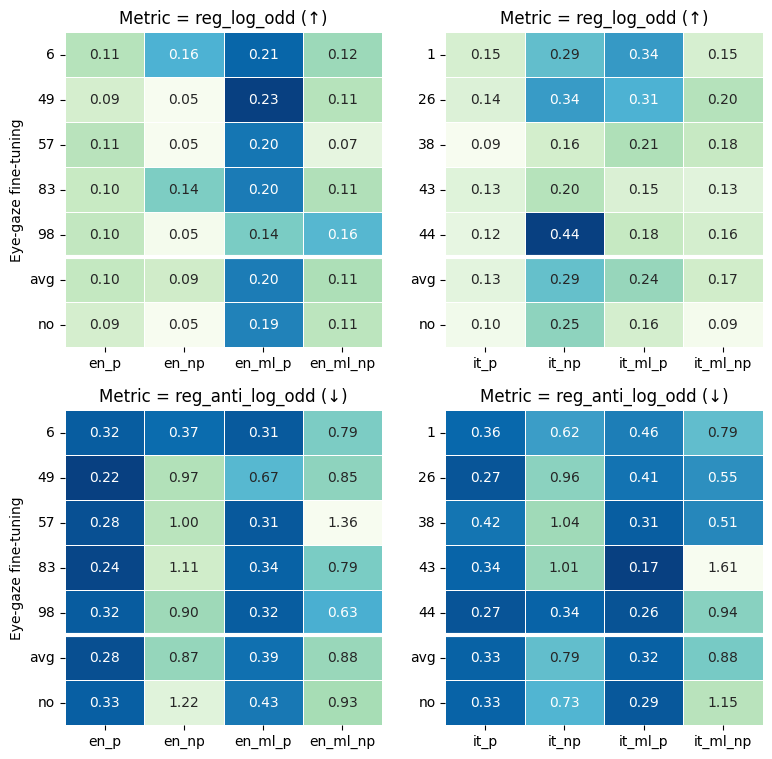

In [15]:
fig, axes = plt.subplots(2, 2,  figsize=(9, 9));

for col_idx, language in enumerate(sorted(all_df['language'].unique())):
    language_df = all_df[all_df['language']==language]
    for row_idx, metric in enumerate(metrics):
        excluded_columns = [m for m in metrics if m != metric] + ['language']#, 'finetuned']
        metric_df = language_df[list(set(language_df.columns.tolist()) - set(excluded_columns))]
        groups = metric_df.groupby(['language_mode', 'pretrained'])
        heatmap_data = create_heatmap_data(groups, language, metric)
        plot_heatmap(heatmap_data, axes[row_idx][col_idx], language, metric)
        
fig.savefig(f'/home/luca/Workspace/augmenting_nlms_meco/output/plots/dig_{task}.png')

# Sentiment

In [12]:
# src_dir_ita =  os.path.join(dig_out_dir, 'sentipolc_10_50')
src_dir_en = os.path.join(dig_out_dir, 'sst2_30_70')
src_dir_ita = None
# src_dir_en = os.path.join(dig_out_dir, 'sst2_10_40')

task = 'sentiment'

In [20]:
all_df = []
for src_dir in [src_dir_en]:#[src_dir_ita, src_dir_en]:
    res_dict = None
    metrics = None
    for model_dir_name in os.listdir(src_dir):
        if not model_dir_name.startswith('roberta'):
            continue
        model_dir_path = os.path.join(src_dir, model_dir_name)
        model_config = get_model_config(model_dir_name)
        model_res = load_dig_results(model_dir_path)
        if res_dict is None:
            res_dict = init_res_dict(model_config, model_res)
            metrics = list(model_res.keys())
        for key, value in model_config.items():
            res_dict[key].append(value)
        for key, value in model_res.items():
            res_dict[key].append(-1*value)
    lang_df = pd.DataFrame.from_dict(res_dict)
    if src_dir == src_dir_ita:
        lang_df['log_odd'] = lang_df[['log_odd_pos', 'log_odd_neg']].mean(axis=1)
        lang_df['anti_log_odd'] = lang_df[['anti_log_odd_pos', 'anti_log_odd_neg']].mean(axis=1)
        lang_df = lang_df.drop(['log_odd_pos', 'log_odd_neg', 'anti_log_odd_pos', 'anti_log_odd_neg'], axis=1)
    all_df.append(lang_df)

In [21]:
all_df = pd.concat(all_df, ignore_index=True)

In [22]:
all_df.head()

,language_mode,pretrained,finetuned,language,user,log_odd,anti_log_odd
0,mono_lingual,False,True,en,57,0.994065,0.382477
1,mono_lingual,True,True,en,57,0.865796,0.501274
2,mono_lingual,True,True,en,83,1.051879,0.345775
3,mono_lingual,True,True,en,49,0.917410,0.402187
4,mono_lingual,True,True,en,6,0.799796,0.339883


In [25]:
def create_heatmap_data(groups, language, metric):
    heatmap_data = None
    columns = metric_df['user'].unique()
    for group_name, group_data in groups:
        label = create_label(language, group_name)
        row_data = pd.DataFrame({user: group_data[group_data['user'] == user][metric].values[0] for user in columns}, index=[label])
        if heatmap_data is None:
            heatmap_data = row_data
        else:
            heatmap_data = pd.concat([heatmap_data, row_data])#, ignore_index=True)
    heatmap_data = heatmap_data.rename(columns={0: 'no'})
    heatmap_data['avg'] = heatmap_data.drop(columns=['no']).mean(axis=1)
    heatmap_data_T = heatmap_data.T
    heatmap_data_T = heatmap_data_T.reindex(sort_index(heatmap_data_T.index))
    return heatmap_data_T[sorted(heatmap_data_T.columns, reverse=True)]

en


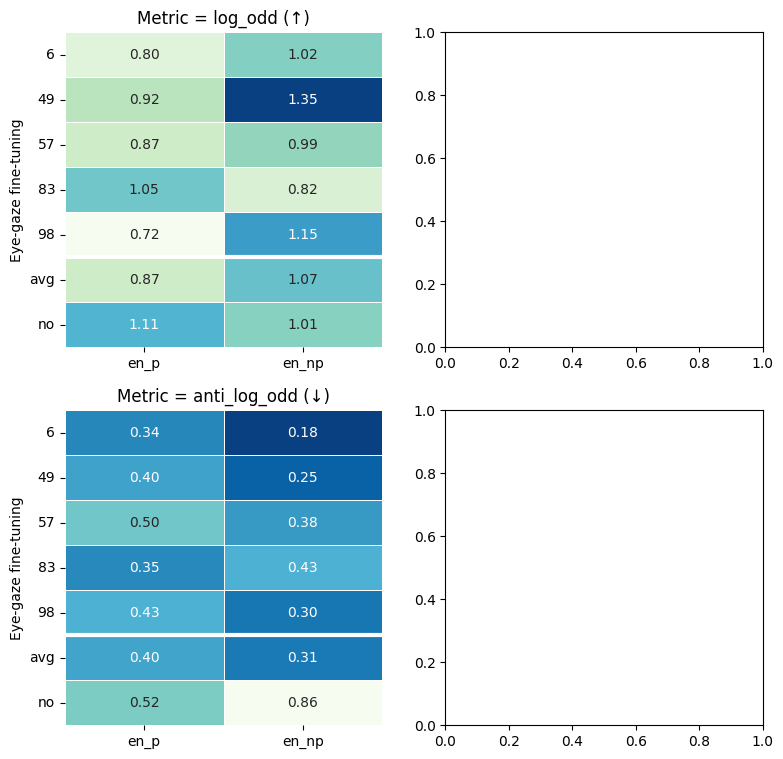

In [26]:
fig, axes = plt.subplots(2, 2,  figsize=(9, 9));

for col_idx, language in enumerate(sorted(all_df['language'].unique())):
    print(language)
    language_df = all_df[all_df['language']==language]
    for row_idx, metric in enumerate(metrics):
        excluded_columns = [m for m in metrics if m != metric] + ['language']#, 'finetuned']
        metric_df = language_df[list(set(language_df.columns.tolist()) - set(excluded_columns))]
        groups = metric_df.groupby(['language_mode', 'pretrained'])
        heatmap_data = create_heatmap_data(groups, language, metric)
        plot_heatmap(heatmap_data, axes[row_idx][col_idx], language, metric)
        
fig.savefig(f'/home/luca/Workspace/augmenting_nlms_meco/output/plots/dig_{task}_2.png')